<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_CC50_regress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных:

In [1]:
!pip install catboost -q
!pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.1 MB/s eta 0:00:00


In [2]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error, make_scorer

# Регрессия с трансформацией цели
from sklearn.compose import TransformedTargetRegressor

from pickle import TRUE
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import joblib

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade_df = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['IC50', 'SI'])
pca_cleaned_CC50 = pd.read_csv(os.path.join(data_dir,'pca_cleaned_CC50.csv'))
tsne_cleaned_CC50 = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_CC50.csv'))
umap_cleaned_CC50 = pd.read_csv(os.path.join(data_dir,'umap_cleaned_CC50.csv'))

In [4]:
# @title Подготовка данных для моделирования
analyse_name = 'regres'
base_parameter = 'CC50'

# подготовка данных для handmade_df
metod_name_1 = 'df_handmade'
X1 = handmade_df.drop(columns=[base_parameter])
y1 = handmade_df[base_parameter]
base_name1 = f"{base_parameter}_{analyse_name}_{metod_name_1}"
csv_file_1 = f"results_{base_name1}.csv"
comparison_file_1 = f"comparison_{base_name1}_"
model_file_1 = f"model_{base_name1}_"

# подготовка данных для pca
metod_name_2 = 'pca'
X2 = pca_cleaned_CC50.drop(columns=[base_parameter])
y2 = pca_cleaned_CC50[base_parameter]
base_name2 = f"{base_parameter}_{analyse_name}_{metod_name_2}"
csv_file_2 = f"results_{base_name2}.csv"
comparison_file_2 = f"comparison_{base_name2}_"
model_file_2 = f"model_{base_name2}_"

# подготовка данных для tsne
metod_name_3 = 'tsne'
X3 = tsne_cleaned_CC50.drop(columns=[base_parameter])
y3 = tsne_cleaned_CC50[base_parameter]
base_name3 = f"{base_parameter}_{analyse_name}_{metod_name_3}"
csv_file_3 = f"results_{base_name3}.csv"
comparison_file_3 = f"comparison_{base_name3}_"
model_file_3 = f"model_{base_name3}_"

# подготовка данных для umap
metod_name_4 = 'umap'
X4 = umap_cleaned_CC50.drop(columns=[base_parameter])
y4 = umap_cleaned_CC50[base_parameter]
base_name4 = f"{base_parameter}_{analyse_name}_{metod_name_4}"
csv_file_4 = f"results_{base_name4}.csv"
comparison_file_4 = f"comparison_{base_name4}_"
model_file_4 = f"model_{base_name4}_"

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [40]:
# @title класс RegressionModelEvaluator для анализа моделей регрессии
class RegressionModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42,
                 log_target=False, models_config=None, metod_name=""):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.log_target = log_target
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name

        # проверка данных
        if log_target and (self.y <= 0).any():
            raise ValueError("все значения y должны быть положительными")

        # логарифмирование целевой переменной
        epsilon = 1e-8
        self.y_transformed = np.log1p(self.y + epsilon) if log_target else self.y

        # разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y_transformed,
            test_size=test_size,
            random_state=random_state
        )

        # инициализация моделей
        if models_config is None:
            self.models = create_models_config(random_state)
        else:
            self.models = models_config

    def create_models_config(random_state=42):
        models_config = {
            # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
            'Ridge': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Ridge()
                ),
                'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
            },
            'Lasso': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Lasso()
                ),
                'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
            },
            'ElasticNet': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    ElasticNet()
                ),
                'params': {
                    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
                }
            },
            # Метод опорных векторов (SVR)
            'SVR': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVR()
                ),
                'params': {
                    'svr__kernel': ['linear', 'rbf', 'poly'],
                    'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
                }
            },
            # Метод k-ближайших соседей (KNN)
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                ),
                'params': {
                    'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsregressor__weights': ['uniform', 'distance'],
                    'kneighborsregressor__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
                }
            },
            # модели деревьев
            'DecisionTree': {
                'model': DecisionTreeRegressor(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5]
                }
            },
            'RandomForest': {
                'model': RandomForestRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5],
                    'max_features': ['sqrt', 0.8]
                }
            },
            # Бустеры
            'GradientBoosting': {
                'model': GradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [None, 5, 10],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostRegressor(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            },
            # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
            #'GLM_Gamma': {
            #    'model': make_pipeline(
            #        StandardScaler(),
            #        TweedieRegressor(power=2, link='log', max_iter=1000)
            #    ),
            #   'params': {
            #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
            #       'tweedieregressor__max_iter': [1000]
            #   }
            #},
            'XGBoost_Tweedie': {
                'model': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.9, random_state=self.random_state),
                'params': {
                    'n_estimators': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost_Tweedie': {
                'model': CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            }
        }
        return models_config


    def evaluate_models(self):
        results = []

        # функция для RMSE
        def rmse(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))

        # make_scorer на основе RMSE
        rmse_scorer = make_scorer(rmse, greater_is_better=False)

        # перебираем модели и гиперпараметры
        for name, model_info in self.models.items():
            model = model_info['model']
            params = model_info['params']

            # подбор параметров через гридсерч
            gs = GridSearchCV(
                model,
                params,
                cv=5,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            gs.fit(self.X_train, self.y_train)

            # лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = -gs.best_score_

            # предсказания
            y_pred = best_model.predict(self.X_test)

            # метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV MSE': cv_score,
                'Test MSE': mean_squared_error(self.y_test, y_pred),
                'Test RMSE': rmse(self.y_test, y_pred),
                'Test MAE': mean_absolute_error(self.y_test, y_pred),
                'Test R2': r2_score(self.y_test, y_pred),
                'Test Explained Variance': explained_variance_score(self.y_test, y_pred),
                'Test Max Error': max_error(self.y_test, y_pred),
                'Test MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'Log Target': self.log_target,
                'Model Object': best_model  # сохраняем саму модель для последующего использования
            }

            results.append(metrics)
            print(f"{name} Test MSE: {metrics['Test MSE']:.3f}")

            # сохраняем лучшую модель
            if self.best_model is None or metrics['Test MSE'] < self.best_model[1]:
                self.best_model = (best_model, metrics['Test MSE'])

        # сохраняем результаты
        self.results = pd.DataFrame(results)
        self.results.set_index('Model', inplace=True)
        self.results = self.results.sort_values('Test MSE')

        return self.results

    def get_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        top_models = []
        for model_name in self.results.index[:n]:
            model_info = {
                'name': model_name,
                'model': self.results.loc[model_name, 'Model Object'],
                'metrics': self.results.loc[model_name].to_dict()
            }
            top_models.append(model_info)

        return top_models

    def save_top_models(self, n=3, prefix='model_',
                       data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")

        os.makedirs(data_dir, exist_ok=True)
        top_models = self.get_top_models(n)

        # сохраняем модели
        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")

        # сохраняем метрики
        metrics_filename = f"{prefix}top_{n}_models_metrics.csv"
        metrics_filepath = os.path.join(data_dir, metrics_filename)

        # создаем DataFrame с метриками
        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Model Object', None)
            metrics.pop('Best Parameters', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X, inverse_transform=False):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")

        preds = self.best_model[0].predict(X)

        if self.log_target and inverse_transform:
            return np.expm1(preds)
        return preds


    def save_model(self, model_name=None, filename='model.pkl',
                  data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        if not hasattr(self, 'results'):
            raise ValueError("Сначала выполните evaluate_models()")
        filepath = os.path.join(data_dir, filename)
        os.makedirs(data_dir, exist_ok=True)
        if model_name is None:
            model = self.best_model[0]
            print(f"Лучшая модель ({model.__class__.__name__}) сохранена в {filepath}")
        else:
            if model_name not in self.results.index:
                raise ValueError(f"Модель {model_name} не найдена. Доступные модели: {list(self.results.index)}")
            best_params = self.results.loc[model_name, 'Best Parameters']
            model = self.models[model_name]['model'].set_params(**best_params)
            model.fit(self.X_train, self.y_train)
            print(f"Модель {model_name} сохранена в {filepath}")

        joblib.dump(model, filepath)

    def compare_top_models_predictions(self, n=3, plot=True, figsize=(15, 10)):
        if self.results is None:
            raise ValueError("Сначала выполните evaluate_models()")
        top_models = self.get_top_models(n)
        # Dataаrame для сравнения
        comparison_df = pd.DataFrame({
            'Actual': self.y if not self.log_target else np.expm1(self.y_transformed)
        })
        # предсказания каждой модели
        for model_info in top_models:
            model_name = model_info['name']
            model = model_info['model']

            # предсказания (с обратным преобразованием если нужно)
            preds = model.predict(self.X)
            if self.log_target:
                preds = np.expm1(preds)

            comparison_df[f'Predicted_{model_name}'] = preds

        if plot:
            plt.figure(figsize=figsize)
            # график фактических и предсказанных значений
            for i, model_info in enumerate(top_models, 1):
                model_name = model_info['name']
                plt.subplot(2, 2, i)
                sns.scatterplot(x='Actual', y=f'Predicted_{model_name}', data=comparison_df)
                plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                         [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                         'r--')
                plt.title(f'Actual vs Predicted ({model_name})')
                plt.xlabel('Actual Values')
                plt.ylabel('Predicted Values')

            # график распределения ошибок
            plt.subplot(2, 2, 4)
            for model_info in top_models:
                model_name = model_info['name']
                errors = comparison_df['Actual'] - comparison_df[f'Predicted_{model_name}']
                sns.kdeplot(errors, label=model_name)
            plt.title('Distribution of Prediction Errors')
            plt.xlabel('Prediction Error')
            plt.legend()

            plt.tight_layout()
            plt.show()

        # расчет метрик ошибок
        metrics_comparison = []
        for model_info in top_models:
            model_name = model_info['name']
            actual = comparison_df['Actual']
            predicted = comparison_df[f'Predicted_{model_name}']

            metrics = {
                'Model': model_name,
                'Full Dataset MSE': mean_squared_error(actual, predicted),
                'Full Dataset RMSE': np.sqrt(mean_squared_error(actual, predicted)),
                'Full Dataset MAE': mean_absolute_error(actual, predicted),
                'Full Dataset R2': r2_score(actual, predicted),
                'Full Dataset MAPE': mean_absolute_percentage_error(actual, predicted)
            }
            metrics_comparison.append(metrics)

        metrics_df = pd.DataFrame(metrics_comparison).set_index('Model')

        return comparison_df, metrics_df

    def save_comparison_results(self, n=3, prefix='comparison_',
                              data_dir='/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'):
        os.makedirs(data_dir, exist_ok=True)
        comparison_df, metrics_df = self.compare_top_models_predictions(n, plot=False)

        # сохраняем предсказания
        predictions_filename = f"{prefix}top_{n}_predictions.csv"
        predictions_filepath = os.path.join(data_dir, predictions_filename)
        comparison_df.to_csv(predictions_filepath, index=False)
        print(f"Предсказания топ-{n} моделей сохранены в {predictions_filepath}")

        # сохраняем метрики
        metrics_filename = f"{prefix}top_{n}_full_metrics.csv"
        metrics_filepath = os.path.join(data_dir, metrics_filename)
        metrics_df.to_csv(metrics_filepath)
        print(f"Метрики топ-{n} моделей на всем датасете сохранены в {metrics_filepath}")

        # сохраняем графики
        self.compare_top_models_predictions(n, plot=True)
        plot_filename = f"{prefix}top_{n}_comparison_plot.png"
        plot_filepath = os.path.join(data_dir, plot_filename)
        plt.savefig(plot_filepath, bbox_inches='tight')
        plt.close()
        print(f"Графики сравнения сохранены в {plot_filepath}")

        return {
            'predictions_file': predictions_filepath,
            'metrics_file': metrics_filepath,
            'plot_file': plot_filepath
        }

In [6]:
# @title Функция визуализации
def plot_prediction_comparison(x, y):
    # Вычисление ошибок предсказания
    errors = x - y

    plt.figure(figsize=(20, 5))

    # График рассеяния
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=x, y=y, alpha=0.5, label='Предсказанные vs Реальные')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Идеальная линия')
    plt.xlabel('Реальные значения IC50')
    plt.ylabel('Предсказанные значения IC50')
    plt.title('Сравнение предсказанных и реальных значений IC50')
    plt.legend()
    plt.tight_layout()

    # Гистограмма ошибок
    plt.subplot(1, 2, 2)
    sns.histplot(errors, bins=30, kde=True, color='purple', alpha=0.6)
    plt.title('Гистограмма ошибок предсказания')
    plt.xlabel('Ошибка предсказания (Реальное - Предсказанное)')
    plt.ylabel('Частота')

    plt.show()

Ridge Test MSE: 2.545
Lasso Test MSE: 1.742
ElasticNet Test MSE: 1.337
SVR Test MSE: 1.192
KNN Test MSE: 1.401
DecisionTree Test MSE: 1.825
ExtraTrees Test MSE: 1.216
RandomForest Test MSE: 1.211
GradientBoosting Test MSE: 1.338
HistGradientBoosting Test MSE: 1.228
XGBoost Test MSE: 1.255
CatBoost Test MSE: 1.191
XGBoost_Tweedie Test MSE: 1.401
CatBoost_Tweedie Test MSE: 1.342
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_df_handmade_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_df_handmade_top_3_full_metrics.csv


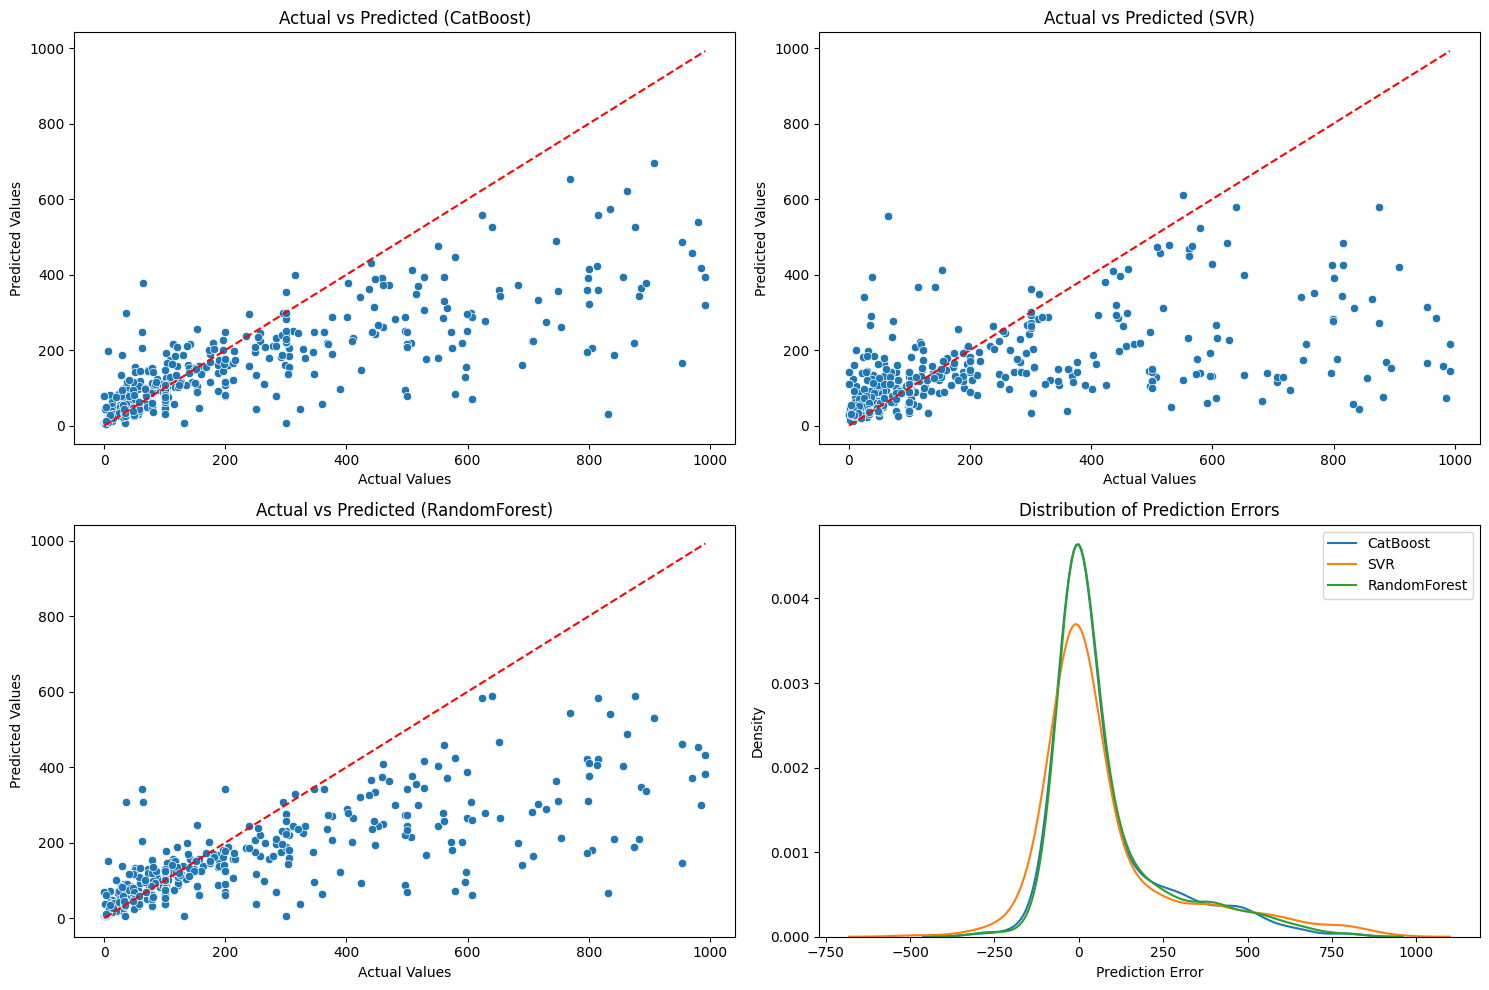

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_df_handmade_top_3_comparison_plot.png
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_catboost.pkl
Модель SVR сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_svr.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_randomforest.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_catboost.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_svr.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_randomforest.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_df_handmade_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на руяных данных
# инициализация
evaluator_handmade_df = RegressionModelEvaluator(X1, y1, log_target=True) # ПОМЕНЯТЬ ТУТ!

# оценка моделей
results = evaluator_handmade_df.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade = results.copy()
results_handmade['metod'] = metod_name_1 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_handmade_df = results_handmade[columns_order]

# предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_handmade_df.predict(X1, inverse_transform=True) # ПОМЕНЯТЬ ТУТ!
predictions_handmade_df = predictions

# сохраненние общего результата
results_handmade_df_id = results_handmade_df.reset_index()
results_handmade_df_id.to_csv(os.path.join(data_dir, csv_file_1), index=False) # ПОМЕНЯТЬ ТУТ!

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_handmade_df.save_comparison_results(n=3, prefix=comparison_file_1, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_handmade_df.save_top_models(n=3, prefix=model_file_1 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_handmade_df.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
CatBoost,df_handmade,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.781084,1.191271,1.091454,0.838055,0.294230,0.304575,3.275902,0.203045,True,<catboost.core.CatBoostRegressor object at 0x7...
SVR,df_handmade,"{'svr__C': 1, 'svr__epsilon': 0.1, 'svr__kerne...",1.877416,1.192319,1.091934,0.879083,0.293609,0.302861,2.768419,0.213906,True,"(StandardScaler(), SVR(C=1))"
RandomForest,df_handmade,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",1.762577,1.211110,1.100504,0.862193,0.282476,0.296068,2.981699,0.207556,True,"(DecisionTreeRegressor(max_depth=10, max_featu..."
ExtraTrees,df_handmade,"{'max_depth': None, 'min_samples_split': 5, 'n...",1.773329,1.216261,1.102842,0.845709,0.279424,0.301276,3.137975,0.201772,True,"(ExtraTreeRegressor(min_samples_split=5, rando..."
HistGradientBoosting,df_handmade,"{'learning_rate': 0.05, 'max_depth': None, 'ma...",1.844796,1.228317,1.108295,0.845599,0.272282,0.278781,3.593688,0.207368,True,HistGradientBoostingRegressor(learning_rate=0....


Ridge Test MSE: 1.572
Lasso Test MSE: 1.742
ElasticNet Test MSE: 1.827
SVR Test MSE: 1.242
KNN Test MSE: 1.335
DecisionTree Test MSE: 2.268
ExtraTrees Test MSE: 1.385
RandomForest Test MSE: 1.358
GradientBoosting Test MSE: 1.323
HistGradientBoosting Test MSE: 1.424
XGBoost Test MSE: 1.282
CatBoost Test MSE: 1.270
XGBoost_Tweedie Test MSE: 1.419
CatBoost_Tweedie Test MSE: 1.369
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_pca_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_pca_top_3_full_metrics.csv


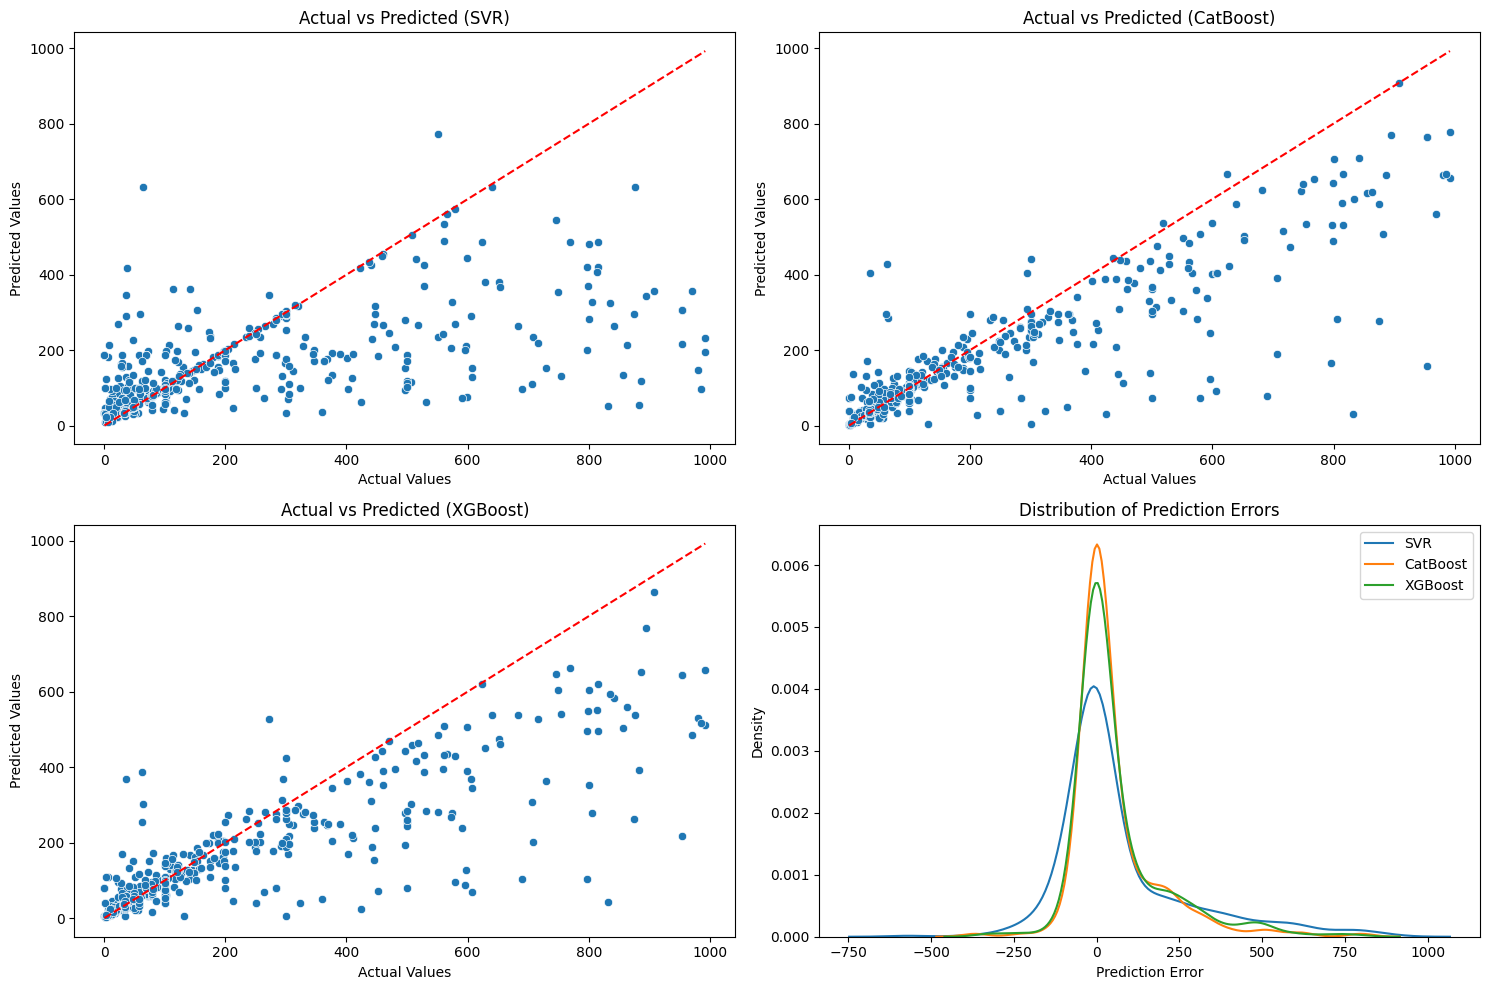

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_pca_top_3_comparison_plot.png
Модель SVR сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_svr.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_catboost.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_xgboost.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_svr.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_catboost.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_xgboost.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_pca_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных PCA(50 параметров)
# Инициализация
evaluator_pca = RegressionModelEvaluator(X2, y2, log_target=True)

# Оценка моделей
results = evaluator_pca.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_pca = results.copy()
results_pca['metod'] = metod_name_2 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_pca = results_pca[columns_order]

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_pca.predict(X2, inverse_transform=False)
predictions_pca = predictions

# Сохраненние результата
results_pca_id = results_pca.reset_index()
results_pca_id.to_csv(os.path.join(data_dir, csv_file_2), index=True)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_pca.save_comparison_results(n=3, prefix=comparison_file_2, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_pca.save_top_models(n=3, prefix=model_file_2 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_pca.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
SVR,pca,"{'svr__C': 1, 'svr__epsilon': 0.01, 'svr__kern...",1.798793,1.242229,1.114553,0.856124,0.264039,0.265553,3.318427,0.216533,True,"(StandardScaler(), SVR(C=1, epsilon=0.01))"
CatBoost,pca,"{'depth': 5, 'iterations': 400, 'l2_leaf_reg':...",1.752270,1.269571,1.126753,0.856689,0.247841,0.261763,3.229690,0.207004,True,<catboost.core.CatBoostRegressor object at 0x7...
XGBoost,pca,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",1.812336,1.282424,1.132442,0.856259,0.240226,0.259456,3.204980,0.204489,True,"XGBRegressor(base_score=None, booster=None, ca..."
GradientBoosting,pca,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",1.842113,1.323489,1.150430,0.866669,0.215897,0.238019,3.562987,0.210140,True,([DecisionTreeRegressor(criterion='friedman_ms...
KNN,pca,"{'kneighborsregressor__n_neighbors': 8, 'kneig...",1.754159,1.335022,1.155432,0.837805,0.209064,0.209812,3.492116,0.210645,True,"(StandardScaler(), KNeighborsRegressor(n_neigh..."


Ridge Test MSE: 1.675
Lasso Test MSE: 1.738
ElasticNet Test MSE: 1.686
SVR Test MSE: 1.705
KNN Test MSE: 1.372
DecisionTree Test MSE: 1.927
ExtraTrees Test MSE: 1.442
RandomForest Test MSE: 1.410
GradientBoosting Test MSE: 1.673
HistGradientBoosting Test MSE: 1.654
XGBoost Test MSE: 1.549
CatBoost Test MSE: 1.501
XGBoost_Tweedie Test MSE: 1.707
CatBoost_Tweedie Test MSE: 1.627
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_tsne_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_tsne_top_3_full_metrics.csv


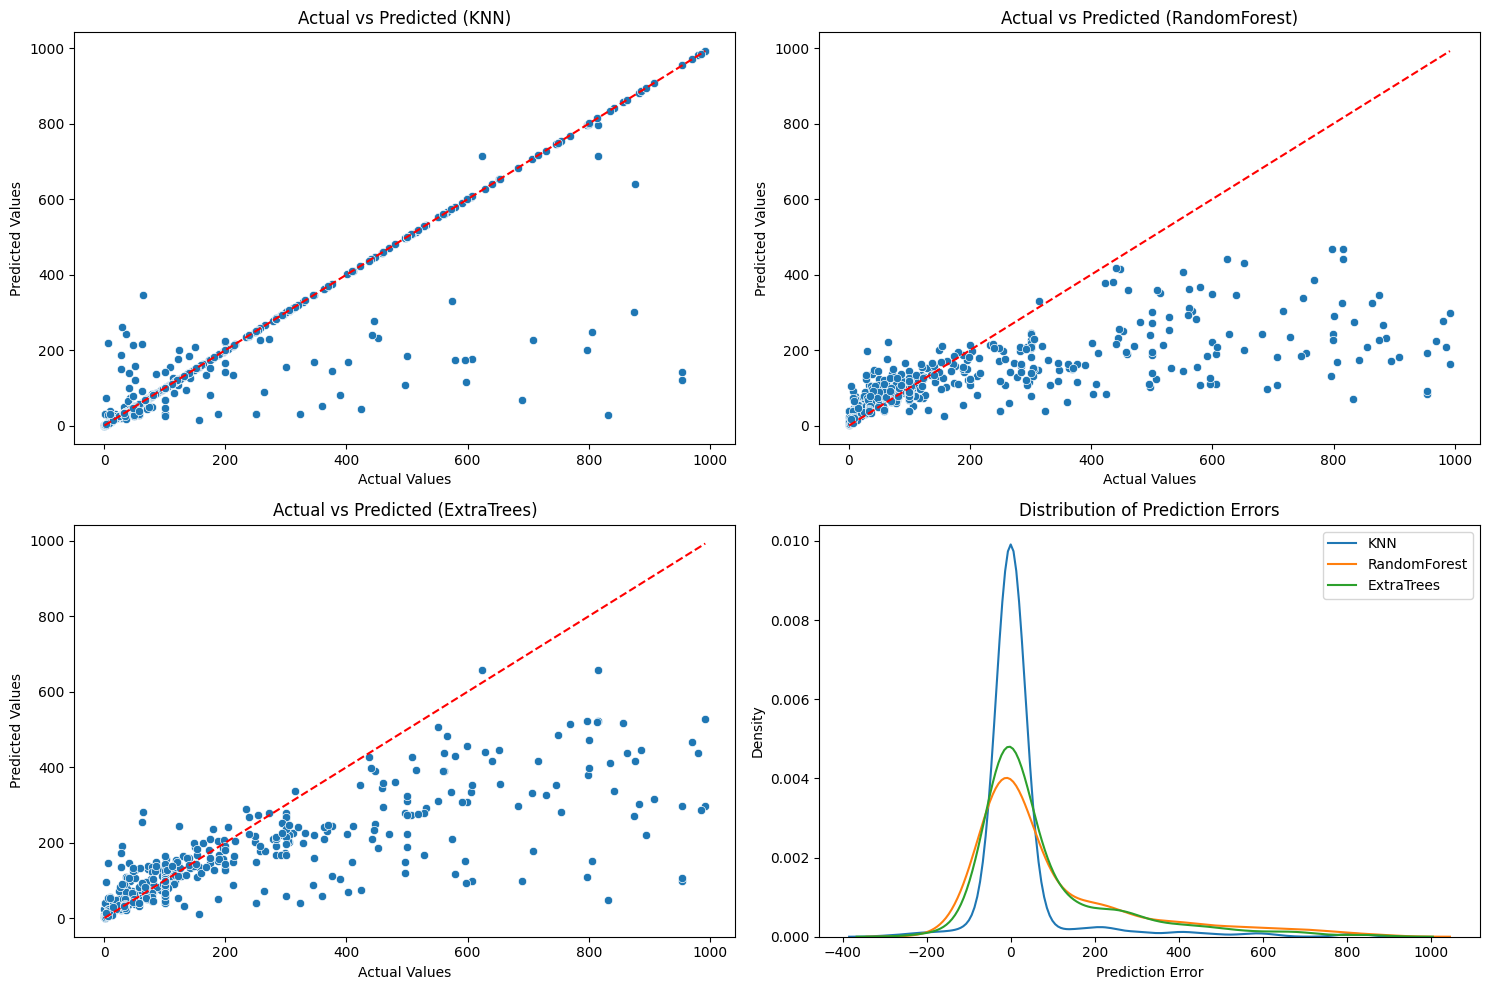

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_tsne_top_3_comparison_plot.png
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_knn.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_randomforest.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_extratrees.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_knn.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_randomforest.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_extratrees.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_tsne_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSME(3 параметра)
# Инициализация
evaluator_tsne = RegressionModelEvaluator(X3, y3, log_target=True)

# Оценка моделей
results = evaluator_tsne.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_tsne = results.copy()
results_tsne['metod'] = metod_name_3
columns_order = ['metod'] + [col for col in results.columns]
results_tsne = results_tsne[columns_order]


# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_tsne.predict(X3, inverse_transform=True)
predictions_tsne_cleaned = predictions

# Сохраненние результата
results_tsne_id = results_tsne.reset_index()
results_tsne_id.to_csv(os.path.join(data_dir, csv_file_3), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_tsne.save_comparison_results(n=3, prefix=comparison_file_3, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_tsne.save_top_models(n=3, prefix=model_file_3 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_tsne.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
KNN,tsne,"{'kneighborsregressor__n_neighbors': 8, 'kneig...",1.942536,1.372057,1.171348,0.905105,0.187123,0.209144,3.360443,0.219591,True,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
RandomForest,tsne,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",2.098427,1.409688,1.187303,0.940918,0.164828,0.180621,3.155004,0.232462,True,"(DecisionTreeRegressor(max_depth=10, max_featu..."
ExtraTrees,tsne,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",2.046210,1.441829,1.200762,0.951827,0.145786,0.165887,3.069099,0.232290,True,"(ExtraTreeRegressor(max_depth=20, min_samples_..."
CatBoost,tsne,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",2.100356,1.500707,1.225034,0.965397,0.110904,0.137221,3.293032,0.234050,True,<catboost.core.CatBoostRegressor object at 0x7...
XGBoost,tsne,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",2.201328,1.549105,1.244631,1.000289,0.082230,0.106508,3.176746,0.242889,True,"XGBRegressor(base_score=None, booster=None, ca..."


Ridge Test MSE: 1.518
Lasso Test MSE: 1.518
ElasticNet Test MSE: 1.518
SVR Test MSE: 1.409
KNN Test MSE: 1.406
DecisionTree Test MSE: 1.599
ExtraTrees Test MSE: 1.352
RandomForest Test MSE: 1.362
GradientBoosting Test MSE: 1.354
HistGradientBoosting Test MSE: 1.370
XGBoost Test MSE: 1.396
CatBoost Test MSE: 1.383
XGBoost_Tweedie Test MSE: 1.487
CatBoost_Tweedie Test MSE: 1.389
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_umap_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_umap_top_3_full_metrics.csv


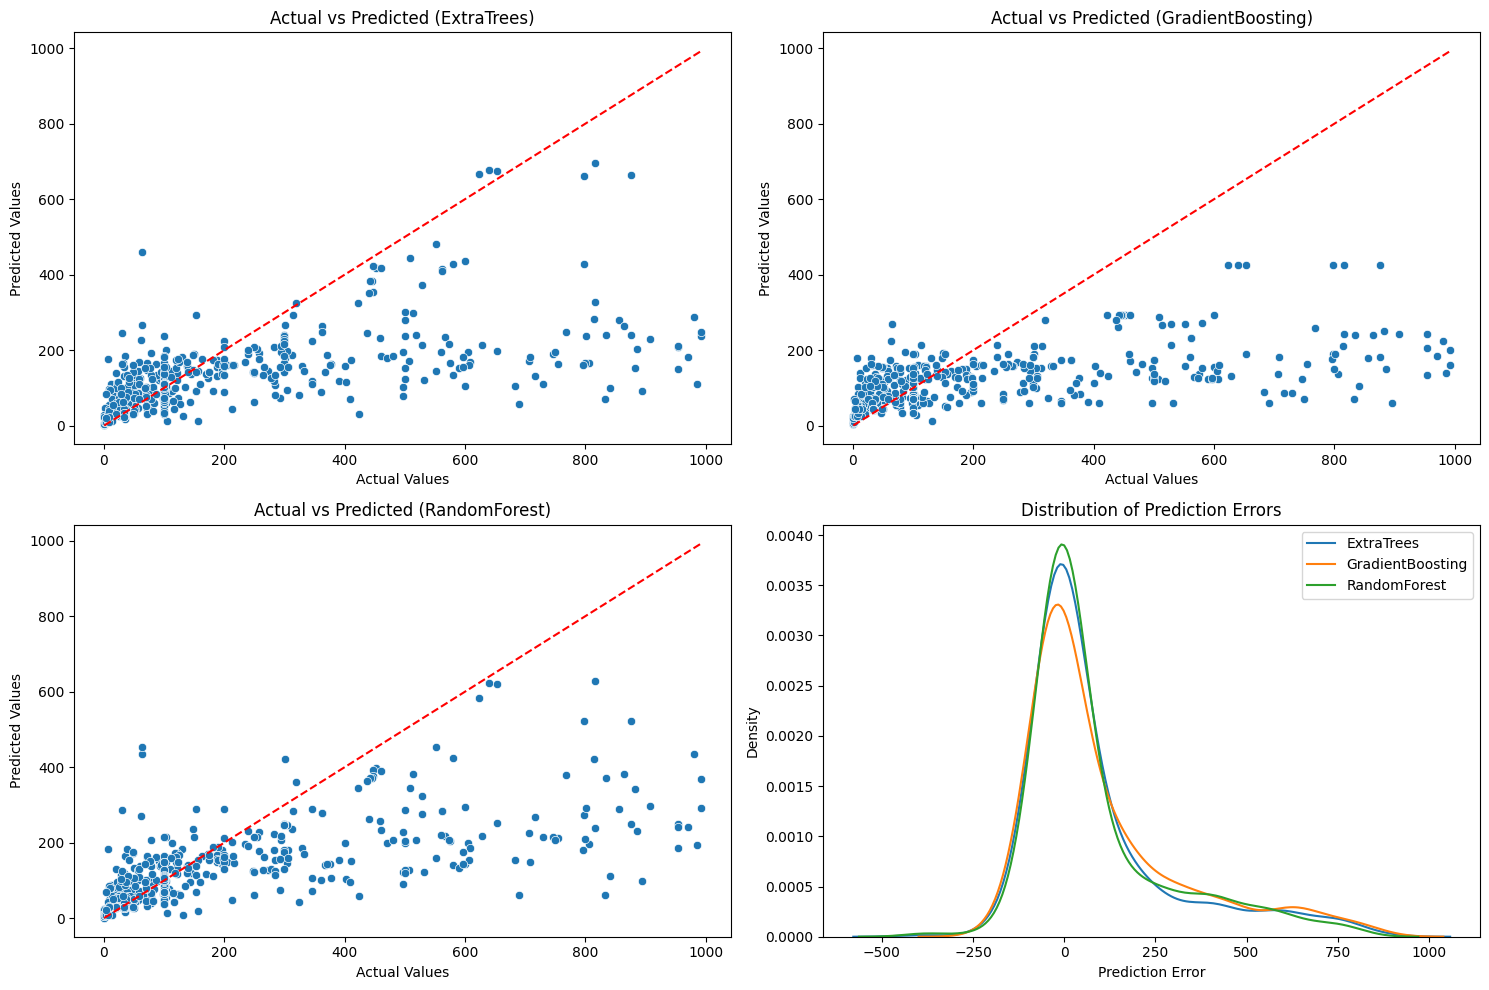

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_umap_top_3_comparison_plot.png
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_extratrees.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_gradientboosting.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_randomforest.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_extratrees.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_gradientboosting.pkl',
  '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_randomforest.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_umap_top_3_models_metrics.csv'}

In [ ]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP (3 параметра)

# Инициализация
evaluator_umap = RegressionModelEvaluator(X4, y4, log_target=True)

# Оценка моделей
results = evaluator_umap.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_umap = results.copy()
results_umap['metod'] = metod_name_4
columns_order = ['metod'] + [col for col in results.columns]
results_umap = results_umap[columns_order]

# Предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_umap.predict(X4, inverse_transform=True)
predictions_umap = predictions

# Сохраненние результата
results_umap_id = results_umap.reset_index()
results_umap_id.to_csv(os.path.join(data_dir, csv_file_4), index=False)

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_umap.save_comparison_results(n=3, prefix=comparison_file_4, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_umap.save_top_models(n=3, prefix=model_file_4 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!

In [ ]:
results_umap.head(5)

,metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
ExtraTrees,umap,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",2.045836,1.351636,1.162599,0.902546,0.199221,0.209610,3.137451,0.221867,True,"(ExtraTreeRegressor(max_depth=10, min_samples_..."
GradientBoosting,umap,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",2.109649,1.353536,1.163416,0.950342,0.198095,0.207329,3.146098,0.235719,True,([DecisionTreeRegressor(criterion='friedman_ms...
RandomForest,umap,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",1.995490,1.362450,1.167240,0.927730,0.192814,0.199861,3.166258,0.229571,True,"(DecisionTreeRegressor(max_depth=10, max_featu..."
HistGradientBoosting,umap,"{'learning_rate': 0.05, 'max_depth': 5, 'max_i...",2.049673,1.369502,1.170257,0.926275,0.188636,0.195504,3.485892,0.230950,True,HistGradientBoostingRegressor(learning_rate=0....
CatBoost,umap,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",1.951597,1.382792,1.175922,0.934995,0.180763,0.195489,3.484807,0.228419,True,<catboost.core.CatBoostRegressor object at 0x7...


# СВОД И ВЫВОДЫ


In [35]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [csv_file_1, csv_file_2, csv_file_3, csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[1]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test MSE', ascending=True)
combined_results_for_view.head(5)

,Model,metod,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object,Data_Type,Unnamed: 0
0,CatBoost,df_handmade,1.781084,1.191271,1.091454,0.838055,0.294230,0.304575,3.275902,0.203045,True,<catboost.core.CatBoostRegressor object at 0x7...,CC50,NaN
1,SVR,df_handmade,1.877416,1.192319,1.091934,0.879083,0.293609,0.302861,2.768419,0.213906,True,"Pipeline(steps=[('standardscaler', StandardSca...",CC50,NaN
2,RandomForest,df_handmade,1.762577,1.211110,1.100504,0.862193,0.282476,0.296068,2.981699,0.207556,True,"RandomForestRegressor(max_depth=10, max_featur...",CC50,NaN
3,ExtraTrees,df_handmade,1.773329,1.216261,1.102842,0.845709,0.279424,0.301276,3.137975,0.201772,True,"ExtraTreesRegressor(min_samples_split=5, n_est...",CC50,NaN
4,HistGradientBoosting,df_handmade,1.844796,1.228317,1.108295,0.845599,0.272282,0.278781,3.593688,0.207368,True,HistGradientBoostingRegressor(learning_rate=0....,CC50,NaN


In [39]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "KNN") & (combined_results['metod'] == "tsne")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'kneighborsregressor__n_neighbors': 8, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}"

In [36]:
# @title Датасет с результатами 12 моделей на всех данных
top3_csv_file_1 = f"{comparison_file_1}top_3_full_metrics.csv"
top3_csv_file_2 = f"{comparison_file_2}top_3_full_metrics.csv"
top3_csv_file_3 = f"{comparison_file_3}top_3_full_metrics.csv"
top3_csv_file_4 = f"{comparison_file_4}top_3_full_metrics.csv"

# Список файлов с результатами
result_files = [top3_csv_file_1, top3_csv_file_2, top3_csv_file_3, top3_csv_file_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем столбец с типом данных (из имени файла)
    data_type = file.split('_')[3]  # Извлекаем 'handmade', 'pca', 'tsne', 'umap'
    df['Data_Type'] = data_type

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
final_results = pd.concat(dfs, ignore_index=False)

# Выводим первые строки для проверки
final_results_for_view = final_results.sort_values(by='Full Dataset MSE', ascending=True)
final_results_for_view.head(5)

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE,Data_Type
0,KNN,13744.181199,117.235580,36.046729,0.782535,0.515597,tsne
1,CatBoost,19649.799880,140.177744,74.291916,0.689095,1.306110,pca
2,XGBoost,23852.714910,154.443242,84.232411,0.622595,1.413629,pca
0,CatBoost,33335.002120,182.578756,104.598450,0.472563,1.566137,df
2,ExtraTrees,34296.120080,185.192117,101.889153,0.457356,1.066021,tsne


In [37]:
final_results

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE,Data_Type
0,CatBoost,33335.002120,182.578756,104.598450,0.472563,1.566137,df
1,SVR,50992.002448,225.814088,130.139279,0.193189,3.603320,df
2,RandomForest,35719.580847,188.996246,106.491810,0.434834,1.479137,df
0,SVR,45469.694913,213.236242,118.525051,0.280565,3.685723,pca
1,CatBoost,19649.799880,140.177744,74.291916,0.689095,1.306110,pca
2,XGBoost,23852.714910,154.443242,84.232411,0.622595,1.413629,pca
0,KNN,13744.181199,117.235580,36.046729,0.782535,0.515597,tsne
1,RandomForest,48394.303723,219.987054,125.292026,0.234291,1.361843,tsne
2,ExtraTrees,34296.120080,185.192117,101.889153,0.457356,1.066021,tsne
0,ExtraTrees,50101.519328,223.833687,128.719508,0.207278,1.356385,umap


In [15]:
# @title ШПАРГАЛКА с гиперпараметрами базовых
""" models_config = {
    # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
    'Ridge': {
        'model': make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            Ridge()
        ),
        'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            Lasso()
        ),
        'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
    },
    'ElasticNet': {
        'model': make_pipeline(
            StandardScaler(),
            PolynomialFeatures(degree=2, include_bias=False),
            ElasticNet()
        ),
        'params': {
            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
            'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    # Метод опорных векторов (SVR)
    'SVR': {
        'model': make_pipeline(
            StandardScaler(),
            SVR()
        ),
        'params': {
            'svr__kernel': ['linear', 'rbf', 'poly'],
            'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
        }
    },
    # Метод k-ближайших соседей (KNN)
    'KNN': {
        'model': make_pipeline(
            StandardScaler(),
            KNeighborsRegressor()
        ),
        'params': {
            'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            'kneighborsregressor__weights': ['uniform', 'distance'],
            'kneighborsregressor__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
        }
    },
    # модели деревьев
    'DecisionTree': {
        'model': DecisionTreeRegressor(random_state=self.random_state),
        'params': {
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [None, 5, 10, 20, 30],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt', 0.8]
        }
    },
    # Бустеры
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingRegressor(random_state=self.random_state),
        'params': {
            'max_iter': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1],
            'max_depth': [None, 5, 10],
            'min_samples_leaf': [10, 20]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=self.random_state),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=self.random_state, silent=True),
        'params': {
            'iterations': [100, 200, 300, 400],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5, 7],
            'l2_leaf_reg': [3, 5, 7]
        }
    },
    # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
    #'GLM_Gamma': {
    #    'model': make_pipeline(
    #        StandardScaler(),
    #        TweedieRegressor(power=2, link='log', max_iter=1000)
    #    ),
    #   'params': {
    #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
    #       'tweedieregressor__max_iter': [1000]
    #   }
    #},
    'XGBoost_Tweedie': {
        'model': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.9, random_state=self.random_state),
        'params': {
            'n_estimators': [200, 300],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'CatBoost_Tweedie': {
        'model': CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=self.random_state, silent=True),
        'params': {
            'iterations': [200, 300],
            'learning_rate': [0.05, 0.1],
            'depth': [3, 5, 7],
            'l2_leaf_reg': [3, 5, 7]
        }
    }
}

evaluator = RegressionModelEvaluator(X1, y1, models_config=my_models_config)
results = evaluator.evaluate_models()"""

" models_config = {\n    # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet\n    'Ridge': {\n        'model': make_pipeline(\n            StandardScaler(),\n            PolynomialFeatures(degree=2, include_bias=False),\n            Ridge()\n        ),\n        'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}\n    },\n    'Lasso': {\n        'model': make_pipeline(\n            StandardScaler(),\n            PolynomialFeatures(degree=2, include_bias=False),\n            Lasso()\n        ),\n        'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}\n    },\n    'ElasticNet': {\n        'model': make_pipeline(\n            StandardScaler(),\n            PolynomialFeatures(degree=2, include_bias=False),\n            ElasticNet()\n        ),\n        'params': {\n            'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],\n            'elasticnet__l1_ratio': [0.2, 0.5, 0.8]\n        }\n    },\n    # Метод опорных векторов (SVR)\n    'SVR': {\n        'model': make_pipe

SVR Test MSE: 1.318
Предсказания топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_final_top_3_predictions.csv
Метрики топ-3 моделей на всем датасете сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_final_top_3_full_metrics.csv


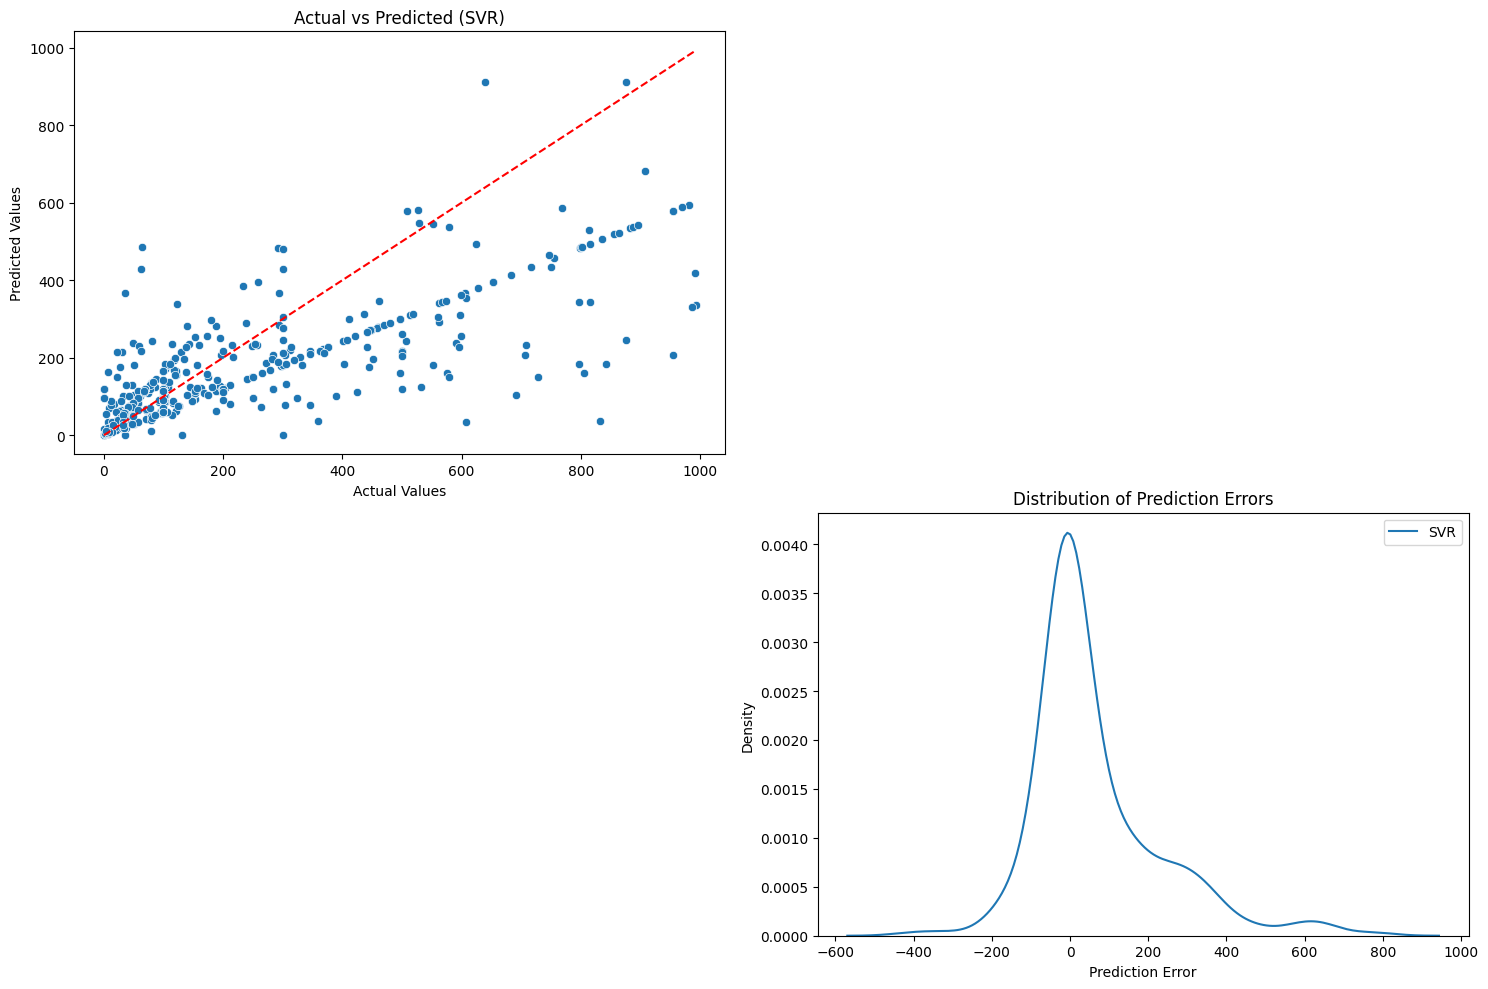

Графики сравнения сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/comparison_CC50_regres_final_top_3_comparison_plot.png
Модель SVR сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_final_svr.pkl
Метрики топ-3 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_final_top_3_models_metrics.csv


{'model_files': ['/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_final_svr.pkl'],
 'metrics_file': '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/model_CC50_regres_final_top_3_models_metrics.csv'}

In [33]:
# @title ТЮНИНГ ТОП 3 МОДЕЛЕЙ
random_state=42

# конструктор имен файлов для сохранения
base_name_final_top3 = f"{base_parameter}_{analyse_name}_final"
csv_file_final_top3 = f"results_{base_name_final_top3}.csv"
comparison_file_final_top3 = f"comparison_{base_name_final_top3}_"
model_file_final_top3 = f"model_{base_name_final_top3}_"

# модели и гиперпараметры
models_config_final_top3 = {
    'SVR': {
        'model': make_pipeline(
            StandardScaler(),
            SVR()
        ),
        'params': {
            'svr__kernel': ['linear', 'rbf', 'poly'],
            'svr__C': [10],
            'svr__epsilon': [0.5]
        }
    }
}
# инициализация
evaluator_top3 = RegressionModelEvaluator(X1, y1, log_target=True, models_config=models_config_final_top3, metod_name=metod_name_1) # ПОМЕНЯТЬ ТУТ!

# оценка моделей
results = evaluator_top3.evaluate_models()

# создаем таблицу с промежуточным результатом для итогового сравнения моделей
results_handmade = results.copy()
results_handmade['metod'] = metod_name_1 # ПОМЕНЯТЬ ТУТ!
columns_order = ['metod'] + [col for col in results.columns]
results_top3 = results_handmade[columns_order]

# предсказания (автоматически преобразуются обратно из логарифмической шкалы)
predictions = evaluator_top3.predict(X1, inverse_transform=True) # ПОМЕНЯТЬ ТУТ!
predictions_top3 = predictions

# сохраненние общего результата
results_top3_id = results_top3.reset_index()
results_top3_id.to_csv(os.path.join(data_dir, csv_file_final_top3), index=False) # ПОМЕНЯТЬ ТУТ!

# сохраненние ТОП 3 моделей с метриками и картинками
evaluator_top3.save_comparison_results(n=3, prefix=comparison_file_final_top3, data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!
evaluator_top3.save_top_models(n=3, prefix=model_file_final_top3 , data_dir=data_dir) # ПОМЕНЯТЬ ТУТ!


In [34]:
# @title Датасет со всеми результатами
top3_csv_file_1 = f"{comparison_file_final_top3}top_3_full_metrics.csv"
file_path = os.path.join(data_dir, top3_csv_file_1 )
df = pd.read_csv(file_path)
df

,Model,Full Dataset MSE,Full Dataset RMSE,Full Dataset MAE,Full Dataset R2,Full Dataset MAPE
0,SVR,31732.358103,178.135786,110.545585,0.497921,2.182771
